# A data analysis exercise on Bitcoin


Working with data gathered from Bitcoin blockchain, this notebook is a simple data analysis exercise, to show:
+ A calculation of the _Gini coefficient_ over the time;
+ How to predict the exchange rate of Bitcoin using machine learning techniques.

Being an exercise, this work does not aim to be accurate, but it would be of help for beginners interested in Python examples like:
+ Working with Pandas datasets;
+ Executing calculus over datasets;
+ Working with Sklearn.

This notebook may be executed on local or dockerize Jupyter servers.

__From Wikipedia__: Bitcoin is a cryptocurrency and a digital payment system invented by an unknown programmer, or a group of programmers, under the name Satoshi Nakamoto. It was released as open-source software in 2009. More details here **https://en.bitcoin.it/wiki/Block_chain**. 


__From Wikipedia__: The Gini coefficient (sometimes expressed as a Gini ratio or a normalized Gini index) is a measure of statistical dispersion intended to represent the income or wealth distribution of a nation's residents, and is the most commonly used measure of inequality.



## Table of Contents

+ Gathering data from Bitcoin
+ Setup
+ The Gini coefficient and Bitcoin
+ Using logistic regression to predict the trend of Bitcoin's exchange rates

## Gathering data from Bitcoin

Bitcoin is permissionless, public blockchain, therefore anyone can join it and read the "ledger".
The site **http://blockchain.info** (more details here **https://blockchain.info/api/blockchain_api**)has been used to download and formatting the data used by this notebook.

disclaimer...

## The Gini coefficient for Bitcoin

Calculating the Gini coefficient for the Bitcoin can be an interesting exercise, nevertheless it could be really tricky. 

Indeed Bitcoin provides pseudo-anonimity and everyone can have more than one wallet and empty wallets, _this aspect inevitably affects the calculations of Gini coefficient, because the total amount of existing wallets does not match the total amount of partecipants_.

Moreover the Bitcoin's ledger only containes the history of committed transactions, consequently it is necessary to execute some logic to have the balance for each existing wallet. Following the logic used to build the data for this notebook.

```python
addressBalance=0
foreach transaction in transactions:

	inputs=transaction.inputs
	outputs=transaction.outputs
	maxlen=max(len(inputs),len(outputs))
	
	foreach i in range(0,maxlen):
		
        # if your address compares as an input of the transaction, it means you are spending Bitcoins
        if (i<len(inputs):
			if (input.addr==a):
			balance-=input.value
		
        # if your address compares as an output of the transaction, it means you are receiving Bitcoins
        if (i<len(outputs):
			if (output.addr==a):
			balance+=output.value
```

## Setup

This section only imports the necessary libraries, as well as it provides global settings and functions.

In [1]:
##################################################################################################################################
# Libraries...
##################################################################################################################################
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##################################################################################################################################
# Settings
##################################################################################################################################
trxFileName = '../data/' + 'gtransactions.csv'
blockFileName = '../data/' + 'gblocks.csv'
exchangeRatesFileName = '../data/' + '2010-2017_USD_BTC.csv'

startYear=2009
endYear=2013
yearLabels=[]
for y in range(startYear,endYear+1):
    yearLabels.append(str(y))

##################################################################################################################################
# Common functions...
##################################################################################################################################
def toDate(millis):
    return datetime.datetime.fromtimestamp(millis).strftime('%Y-%m-%d %H:%M:%S')

def toRatesDate(datelabel):
    return datetime.datetime.strptime(datelabel, '%Y-%m-%d %H:%M:%S')

def toRatesDay(datelabel):
    mydate=datetime.datetime.strptime(datelabel, '%Y-%m-%d %H:%M:%S')
    return int(mydate.strftime('%Y%m%d'))
                                      
def toMonthYear(millis):
    floatMillis=float(millis)
    return str(datetime.datetime.fromtimestamp(floatMillis).strftime('%Y%m'))
    
def toYear(millis):
    floatMillis=float(millis)
    return int(datetime.datetime.fromtimestamp(floatMillis).strftime('%Y'))

def toBTC(satoshiL):
    satoshi=float(satoshiL)
    btc=float(satoshi/100000000)
    return btc

## Calculating the Gini coefficient

This paragraph exaplains the method used by this notebook to calculate the Gini coefficient.

The starting point is the below table (data is fictional).

|i  |Xi |
|---|---|
|1  |2  |
|2  |3  |
|3  |6  |
|4  |9  |
|5  |10 |

+ column **i** is just a sequential index of records
+ column **Xi** lists the balances, one for each existing wallet, _from the smallest to the greatest_


### Adding column **TXi**

$$TXi=\sum_{j=1}^i Xj$$

|i  |Xi |TXi      |
|---|---|---------|
|1  |2  |        2|
|2  |3  |        5|
|3  |6  |       11|
|4  |9  |       20|
|5  |10 |       30|

TXi is the sum of all wallets from index 1 to index i.


### Adding column **Pi**

$$Pi=\frac{i}{n}$$  

where __n__ is the total number of records (that is the total number of existing wallets).


|i  |Xi |TXi      |Pi     |
|---|---|---------|-------|
|1  |2  |        2|    0.2|
|2  |3  |        5|    0.4|
|3  |6  |       11|    0.6|
|4  |9  |       20|    0.8|
|5  |10 |       30|      1|


### Adding column **Qi**

$$Qi=\frac{\sum_{j=1}^i Xj}{\sum_{j=1}^n Xj}$$


|i  |Xi |TXi      |Pi     |Qi     |
|---|---|---------|-------|-------|
|1  |2  |        2|    0.2|  0,066|
|2  |3  |        5|    0.4|  0,166|
|3  |6  |       11|    0.6|  0,366|
|4  |9  |       20|    0.8|  0,666|
|5  |10 |       30|      1|      1|


where: 

$${\sum_{j=1}^n Xj}$$ 

is the total amount of existent Bitcoins (in the above sample this value is 30 Bitcoins)  


### Adding column **Pi-Qi**


$$Pi-Qi=Pi - Qi


|i  |Xi |TXi      |Pi     |Qi     |Pi-Qi     |
|---|---|---------|-------|-------|----------|
|1  |2  |        2|    0.2|  0,066|     0,133|
|2  |3  |        5|    0.4|  0,166|     0,233|
|3  |6  |       11|    0.6|  0,366|     0,233|
|4  |9  |       20|    0.8|  0,666|     0,133|
|5  |10 |       30|      1|      1|         0|



### Gini coefficient


GIni coefficient is:

*$$\frac{\sum_{i=1}^{n-1} Pi-Qi}{\sum_{i=1}^{n-1} Pi}$$*  

Considering the fictional example, the Gini coefficient is around __0,366__.


__Note that the gathered data for this notebook only considered the non zero wallets as the population.__

### Loading data...

Gathered data from Bitcoin are:
+ 2009_balances.csv
+ 2010_balances.csv
+ 2011_balances.csv
+ 2012_balances.csv
+ 2013_balances.csv

In [2]:
pdBalanceByYear=[]
for y in range(startYear,endYear+1):
    data=pd.read_csv('../data/' + str(y)+'_ybalances.csv')
    pdBalanceByYear.append(data)

Each file contains aggregated data for a specific year:

- year
- wallet id
- amount of Bitcoin

In [3]:
pdBalanceByYear[0].head(2)

year                                addr  amount  addir
0  2009  1121cQLqCsDsLPAkJW5ddTCREZ7Bp4ufrk      50      0
1  2009  1123CbSL5FsetAi7za8gMBYjNHhuCURDPC      50      0

### Total amount of Bitcoin and wallets per year

The first steps to calculate the Gini coefficient is to have:
* __the total number of existing Bitcoin addresses at each specific year__
* __the total amount of available Bitcoins at each specific year__

In [4]:
allBitcoinOfYear=[] # the next variable contains the list of the total amount of available Bitcoins for each year
allAddressOfYear=[] # the next variable contains the list of the total number of existing address for each year

for y in range(startYear,endYear+1):
    temp = pdBalanceByYear[y-startYear]
    temp.sort_values(by='amount', ascending=True, inplace=True)
    allBitcoinOfYear.append(temp['amount'].sum()) #get the total amount of available Bitcoins for the current year
    allAddress = temp['addr'].count() #get the total numebr of existing addresses for the current year
    allAddressOfYear.append(allAddress)

### How total amount of Bitcoin and wallets changed year by year

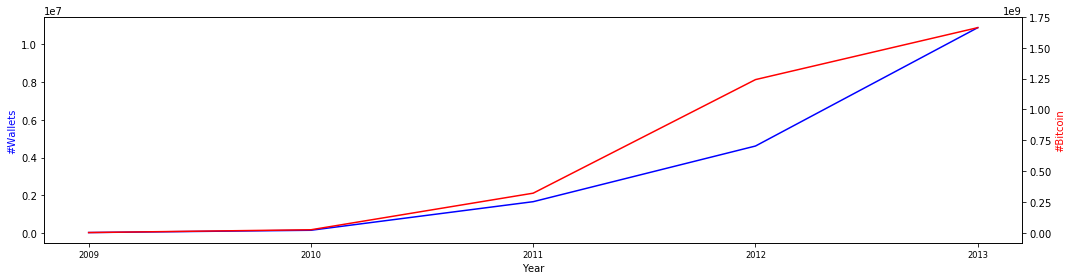

In [5]:
fig, ax1=plt.subplots(figsize=(15,4))

labels=['2009','-','2010','-','2011','-','2012','-','2013']

ax1.plot(yearLabels, allAddressOfYear, 'b-')
ax1.set_xlabel('Year')
ax1.set_ylabel('#Wallets', color='b')
ax1.set_xticklabels(labels, size='small')

ax2 = ax1.twinx()
ax2.plot(yearLabels, allBitcoinOfYear, 'r-')
ax2.set_ylabel('#Bitcoin', color='r')

fig.tight_layout()
plt.show()

### Indexing the dataset

Looking at the method explained to calculate Gini coefficient, this task adds the index column for each year.

In [6]:
for i in range(0,len(pdBalanceByYear)):
    pdBalanceByYear[i].loc[:,'id'] = range(1,len(pdBalanceByYear[i])+1)

pdBalanceByYear[0].head(5)

year                                addr  amount  addir  id
5461   2009  15rXpfXauzXaHcdNef5Aq1nAvZsMQ26xZQ       1      0   1
1501   2009  12yrUmFBpsoh9CrV38LyxsAtJ4Y7ymNJ7y       1      0   2
26765  2009  1LsbJouWZswhBe2C4uL1122aXco8AovUbk       1      0   3
27002  2009  1M3aHxpG6dD1qVojvfHUvTczoDXoJNN2c2       1      0   4
1941   2009  13HtsYzne8xVPdGDnmJX8gHgBZerAfJGEf       1      0   5

### Adding column 'Pi' for each year

In [8]:
for i in range(0,len(pdBalanceByYear)):
    pdBalanceByYear[i]['Pi'] = pdBalanceByYear[i]['id'] / allAddressOfYear[i]

pdBalanceByYear[0].head(5)

year                                addr  amount  addir  id        Pi
5461   2009  15rXpfXauzXaHcdNef5Aq1nAvZsMQ26xZQ       1      0   1  0.000031
1501   2009  12yrUmFBpsoh9CrV38LyxsAtJ4Y7ymNJ7y       1      0   2  0.000061
26765  2009  1LsbJouWZswhBe2C4uL1122aXco8AovUbk       1      0   3  0.000092
27002  2009  1M3aHxpG6dD1qVojvfHUvTczoDXoJNN2c2       1      0   4  0.000123
1941   2009  13HtsYzne8xVPdGDnmJX8gHgBZerAfJGEf       1      0   5  0.000153

In [9]:
pdBalanceByYear[0].tail(3)

year                                addr  amount  addir     id  \
19349  2009  1Ff2xcJtfWWiNRCTUuTng6TJQm3g8h61Y2   22500      0  32596   
1078   2009  12higDjoCCNXSA95xZMWUdPvXNmkAduhWv   61423      0  32597   
17491  2009  1EMPhwUXHGURtSdt5zidbV3zPKruDTKYX9   87500      0  32598   

             Pi  
19349  0.999939  
1078   0.999969  
17491  1.000000

### Adding the column 'Qi'

This task requires two steps and __the execution might last several minutes!__

In [10]:
for y in range(0,len(pdBalanceByYear)):
    psValueCol = []
    for i in range(len(pdBalanceByYear[y])):
        if (i == 0):
            psValue = sum(pdBalanceByYear[y]['amount'][0:1])
            previous = psValue
        else:
            psValue = previous + sum(pdBalanceByYear[y]['amount'][i:i+1])
            previous = psValue
        psValueCol.append(psValue)
    pdBalanceByYear[y]['psValue'] = psValueCol 

Next step adds the 'Qi' column to each dataset (one per year).

In [12]:
for y in range(0,len(pdBalanceByYear)):
    pdBalanceByYear[y]['Qi']=pdBalanceByYear[y]['psValue']/allBitcoinOfYear[y]
    
pdBalanceByYear[0].tail(3)

year                                addr  amount  addir     id  \
19349  2009  1Ff2xcJtfWWiNRCTUuTng6TJQm3g8h61Y2   22500      0  32596   
1078   2009  12higDjoCCNXSA95xZMWUdPvXNmkAduhWv   61423      0  32597   
17491  2009  1EMPhwUXHGURtSdt5zidbV3zPKruDTKYX9   87500      0  32598   

             Pi  psValue        Qi  
19349  0.999939  1828174  0.924676  
1078   0.999969  1889597  0.955743  
17491  1.000000  1977097  1.000000

### Adding the column 'Pi-Qi'

In [13]:
for i in range(0,len(pdBalanceByYear)):
    pdBalanceByYear[i]['Pi-Qi'] = pdBalanceByYear[i]['Pi'] - pdBalanceByYear[i]['Qi']
pdBalanceByYear[0].tail(3)

year                                addr  amount  addir     id  \
19349  2009  1Ff2xcJtfWWiNRCTUuTng6TJQm3g8h61Y2   22500      0  32596   
1078   2009  12higDjoCCNXSA95xZMWUdPvXNmkAduhWv   61423      0  32597   
17491  2009  1EMPhwUXHGURtSdt5zidbV3zPKruDTKYX9   87500      0  32598   

             Pi  psValue        Qi     Pi-Qi  
19349  0.999939  1828174  0.924676  0.075263  
1078   0.999969  1889597  0.955743  0.044226  
17491  1.000000  1977097  1.000000  0.000000

### Get the Gini coefficient per year.

In [14]:
giniIndex = pd.DataFrame(columns=('Year', 'Index'))

for y in range(0,len(pdBalanceByYear)):
    num = sum(pdBalanceByYear[y]['Pi-Qi'])
    den = sum(pdBalanceByYear[y]['Pi'][0:len(pdBalanceByYear[y])-1])
    index = num/den
    giniIndex.loc[y] = [yearLabels[y],index]

giniIndex.head(5)

Year     Index
0  2009  0.177048
1  2010  0.749119
2  2011  0.889043
3  2012  0.930073
4  2013  0.923681

### How Gini coefficient changed year by year

[Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013')]

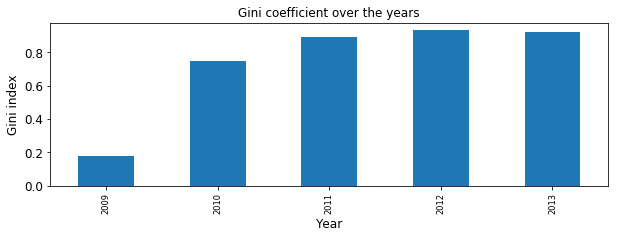

In [15]:
axis = giniIndex['Index'].plot(kind='bar', title ="Gini coefficient over the years",figsize=(10,3),legend=False, fontsize=12)
axis.set_xlabel("Year",fontsize=12)
axis.set_ylabel("Gini index",fontsize=12)
axis.set_xticklabels(yearLabels, size='small')

## Predicting Bitcoin's exchange rate trend using a binary classifier

A binary classifier is a supervised machine learning model to predict a categoral variable, which can have one of only two possible values.

Some details here: https://en.wikipedia.org/wiki/Binary_classification

This notebook uses a logistic regression model to predict the rende of Bitcoin exchange price.
The trend variable is:

-  1  : if the next day price grows
- -1 : if the next day price decreases 

A binary classifier uses a set of independet variables, called features, which appear to be good predictors of the variable trend. Finding the best features is not trivial, but they are vital to have a good binary classifier.

### Loading data and building the source dataset

The final source dataset contains potential features and the trend variable.

The notebook build the source dataset from different files:

- data of committed transactions on Bitcoin
- data of calculated blocks of Bitcoin
- history of exchanged Bitcoin price (in dollars) per day

Some dataset requires some formatting actions:

- sorting the records by day
- removing unecessary rows
- transforming columns to float type
- etc

In [16]:
trx = pd.read_csv(trxFileName)
trx['day'] =trx.astype('int')
trx.sort_values(['day'], ascending=True, inplace=True)
trx.tail(2)

day  asize  ntrx
2189  20141230    0.0     0
2190  20141231    0.0     0

In [17]:
blocks = pd.read_csv(blockFileName)
blocks.columns = ['day', 'afee', 'b_asize', 'atrx', 'nblocks']
blocks.sort_values(['day'], ascending=True, inplace=True)
blocks.tail(2)

day  afee  b_asize  atrx  nblocks
2189  20141230   0.0      0.0   0.0        0
2190  20141231   0.0      0.0   0.0        0

In [18]:
allrates = pd.read_csv(exchangeRatesFileName)

In [19]:
allrates['day']        = allrates['Date'].apply(lambda x: toRatesDay(x))
allrates['day']        = allrates['day'].astype(int)
allrates['price']      = allrates['Close Price'].astype(float)
allrates               = allrates[['day', 'price']]
rates                  = allrates[allrates['day']<20140101]
rates.reset_index
rates.head(2)

day  price
0  20100718   0.09
1  20100719   0.08

__Now, data coming from different files must be merged into one single dataset, using column day as key__

In [20]:
temp     = pd.merge(trx, blocks, on='day', how='left')
data     = pd.merge(temp, rates, on='day', how='right')
data.head(5)

day       asize  ntrx  afee      b_asize      atrx  nblocks  price
0  20100718  313.402381   420   0.0   846.284884  2.441860      172   0.09
1  20100719  249.149621   528   0.0   837.040230  3.034483      174   0.08
2  20100720  300.053872   594   0.0  1065.707182  3.281768      181   0.07
3  20100721  242.535637   463   0.0   623.483092  2.236715      207   0.08
4  20100722  218.073048   397   0.0   572.903409  2.255682      176   0.05

Here the explaination of available column of the single dataset:
 
+ day     : day in the format yyyymmdd
+ asize   : average size (in terms of bytes) of transactions per day
+ ntrx    : number of committed transactions per day
+ afee    : the average fee applied to the add block into blockchain per day
+ b_asize : average size (in terms of bytes) of blocks per day
+ atrx    : average transaction into each block per day
+ nblocks : total blocks added to blockchain per day

### Adding the column trend

In order to learn how to predict one variable, a supervised machine learning model must be trained over a historical dataset. 

Our binary classifier has to learn how to predict the next __day__ Bitcoin exchange rate __trend__, therefore it is necessary a historical dataset of several days. Even if it could appear easy, deciding the size of the historical dataset is not so trivial. Thinking of Bitcoin, the behaviour of the exchange price could be significantly different between early years and recent years. A first approach could be using only the last two years.

Anyway, the historical dataset must contains one record per day and each row must contain:

- the values of all column considered features
- the actual value of the trend 

Out potential _training_ dataset does not contain the trend column, but luckly this variable can be easily calculated.

In [21]:
sources = data['price'].tolist()
targets = []
for i in range(0,len(sources)):
    if i == len(sources) - 1:
        targets.append(np.NaN)
    else:
        if sources[i] <= sources[i + 1]:
            targets.append(1)
        else:
            targets.append(-1)
data['trend'] = targets
data.dropna(how='any', inplace=True)
data['trend'] = data['trend'].astype(int) # values MUST be integers, due to the nature of the binary classifier
data.head(5)

day       asize  ntrx  afee      b_asize      atrx  nblocks  price  \
0  20100718  313.402381   420   0.0   846.284884  2.441860      172   0.09   
1  20100719  249.149621   528   0.0   837.040230  3.034483      174   0.08   
2  20100720  300.053872   594   0.0  1065.707182  3.281768      181   0.07   
3  20100721  242.535637   463   0.0   623.483092  2.236715      207   0.08   
4  20100722  218.073048   397   0.0   572.903409  2.255682      176   0.05   

   trend  
0     -1  
1     -1  
2      1  
3     -1  
4      1

### Is the dataset balanced?

Now the training dataset contains the __trend__ column, so it is possible to calculate how many times the next day Bitcoin's prices has been growth, and how many times it has been decreased.

In [22]:
total     = len(data)
grows     = len(data[data['trend'] == 1]) * 100 / len(data)
decreases = len(data[data['trend'] == -1]) * 100 / len(data)
print('Total records  = ' + str(total))
print('Total grows    = ' + str(grows) + ' %')
print('Total decreses = ' + str(decreases) + ' %')

Total records  = 1233
Total grows    = 61.96269261962693 %
Total decreses = 38.03730738037307 %


A variable to be predicted by a binary classifier can have only one of two possible values, in our case the variable trend can be 1 or -1, consequently the dataset is called:

- balanced    : if the percentage of one possible value is about the same as in the other possible value
- unbalanced  : if the percentage of one possible value is significantly greater than in the other possible value

The balancing of the dataset is an important aspect, because unbalanced dataset require specific classification models, like the autoencoder neural network.

### Selecting the features

Selecting the best features for training the binary classifier requires a deep analysis of the available data, involving domain experts. In our case, domain experts must have competence on crypto currency financial market.

Data analysis includes many methods, for example the visual analysis of the possible correlation between two variables, the calculation of correlation index between variables, etc.

#### Looking at the possible correlation between applied fee and Bitcoin's price

The transfer of Bitcoin from one wallet to another requires the payment of a fee. So it makes sense to check if there is a potential correlation between the fees and the Bitcoin's price.

Below graph shows how average fees and Bitcoin's price changed over the time.

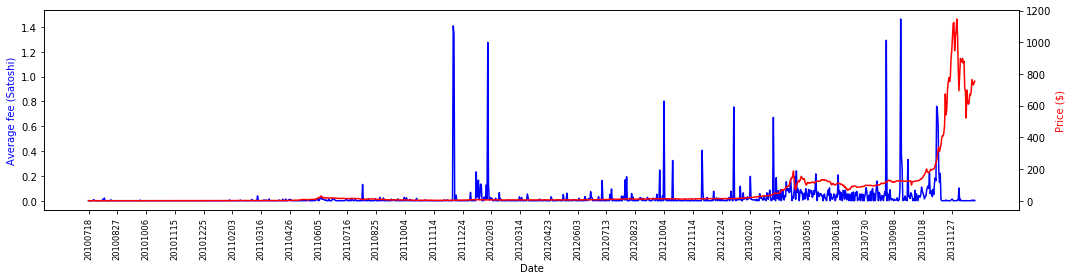

In [23]:
fig, ax1=plt.subplots(figsize=(15,4))

n=40
ax1.set_xlabel('Date')
ax1.set_ylabel('Average fee (Satoshi)', color='b')
ax1.set_xticks(data['day'][::n].index)
ax1.set_xticklabels(data['day'][::n].values,size='small', rotation=90)
ax2 = ax1.twinx()
ax2.set_ylabel('Price ($)', color='r')

ax1.plot(data['afee'].values, 'b-')
ax2.plot(data['price'].values, 'r-')
fig.tight_layout()
plt.show()

#### Looking at the possible correlation between mined block and Bitcoin's price

Below graph shows how average mined block per day and the number of transactions per block changed over the time.

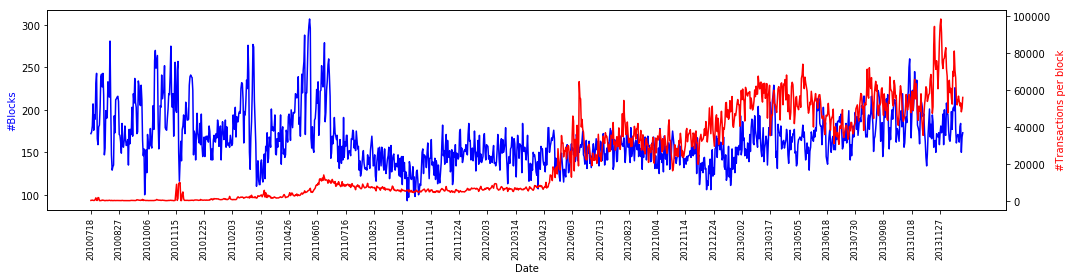

In [24]:
fig2, fig2_ax1=plt.subplots(figsize=(15,4))

fig2_ax1.set_xlabel('Date')
fig2_ax1.set_ylabel('#Blocks', color='b')
fig2_ax1.set_xticks(data['day'][::n].index)
fig2_ax1.set_xticklabels(data['day'][::n].values,size='small', rotation=90)

fig2_ax2 = fig2_ax1.twinx()
fig2_ax2.set_ylabel('#Transactions per block', color='r')

fig2_ax1.plot(data['nblocks'].values, 'b-')
fig2_ax2.plot(data['ntrx'].values, 'r-')

fig2.tight_layout()
plt.show()

#### Pearson correlation coefficient between variables

The Pearson correlation ciefficiet is _is a measure of the linear correlation between two variables_, more details here:
https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Below graph shows a visual and easy map of the Pearson coefficient between all the possible couple of variables extracted from our training dataset.

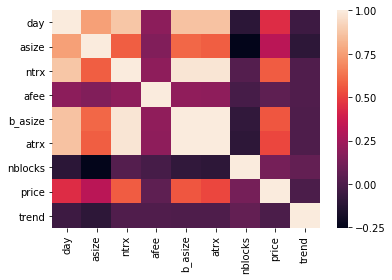

In [25]:
sb.heatmap(data.corr())

The Pearson coefficient ranges from -1 to +1, and:

- values close to  1 indicates a positive linear correlation
- values close to  0 indicates no linear correlation
- values close to -1 indicates a negative linear correlation

Looking at the heatmap, good features are variables which have a Pearson coefficient close to 1 or -1 against the variable __trend__. 

While features which have a Pearson coefficient close to 0 against the variable __trend__ should be discarded.

It appears that there are not really good features.

#### Trying some features

Our attempt to train the binary classifier uses the following features: 

In [26]:
feature_names = ['nblocks', 'afee', 'ntrx']
for f in feature_names:
    print('- ' + f)

- nblocks
- afee
- ntrx


### Training and test of a binary classifier

Training and test requires two separated datasets, for this reason the dataset _data_ will be splitted in two different parts.

The 70% of the dataset _data_ will be used to train the binary classifier, while the 30% will be use for testing.

Moreover, the data of features must be separated by the column of _trend_.

In [28]:
features   = data[feature_names].values # getting only the selected features
prediction = data[['trend']].values     # getting only the column of trend
features_train, features_test, prediction_train, prediction_test = train_test_split(features, prediction, test_size=.3, random_state=25)

#### Train the logistic regression model

There are many ways to implement a binary classifier, our attempt uses the logistic regression, that is a machine learning supervised model provided by Sklearn library.

During the training, the model will learn looking at the features and the actual values of the _trend_.

In [29]:
logisticRegression = LogisticRegression()
logisticRegression.fit(features_train, prediction_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Testing

The result of a test is a dataset containing for each record the predicted trend and the actual value of the trend.

In [30]:
test_result=logisticRegression.predict(features_test)

One common way to measure the performance of a binary classifier is confusion matrix (detail here  *https://en.wikipedia.org/wiki/Confusion_matrix*).

Sklearn provides a function to calculate the confusion matrix data from the test's results:

+ number of true negatives  : model correctly predicted a decrease of Bitcoin's price
+ number of false negatives : model wrongly predicted a decrease of Bitcoin's price
+ number of true positives  : model correctly predicted a growth of Bitcoin's price
+ number of false positives : model wrongly predicted a growth of Bitcoin's price

From the confusion matrix derives other performance metrics like:

+ Precision
+ Accuracy
+ F1 score
+ etc.

In [31]:
cm = confusion_matrix(prediction_test, test_result)
print('True negatives  ' + str(cm[0][0]))
print('False positives ' + str(cm[0][1]))
print('False negatives ' + str(cm[1][0]))
print('True positives  ' + str(cm[1][1]))
accuracy=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Accuracy        ' + str(accuracy))

True negatives  0
False positives 133
False negatives 0
True positives  237
Accuracy        0.6405405405405405


In [32]:
print(classification_report(prediction_test, test_result))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       133
           1       0.64      1.00      0.78       237

   micro avg       0.64      0.64      0.64       370
   macro avg       0.32      0.50      0.39       370
weighted avg       0.41      0.64      0.50       370



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Authors

Angelo Littera is a passionate of technologies, especially artificial intelligence and blockchain.